# Подготовка окружения

In [1]:
%pip install -U pip setuptools
%pip install scikit-learn pandas matplotlib tqdm pydot-ng graphviz numba torch scipy==1.10
%pip install tensorflow keras==2.15
%pip install sentence-transformers gensim simple_elmo

%pip install spacy[cuda12x]
!nvidia-smi

  Using cached setuptools-70.0.0-py3-none-any.whl.metadata (5.9 kB)
Using cached setuptools-70.0.0-py3-none-any.whl (863 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.6.0
    Uninstalling setuptools-59.6.0:
      Successfully uninstalled setuptools-59.6.0
Note: you may need to restart the kernel to use updated packages.
  Using cached scikit_learn-1.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached matplotlib-3.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached pydot_ng-2.0.0-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached numba-0.59.1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
  Using cached t

In [2]:
!spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 11.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
# общее
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import numba
from tqdm import tqdm

import gc
gc.collect()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


# анализ текста
import spacy
spacy.require_gpu()
nlp = spacy.load("en_core_web_lg")

# векторайзеры
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from numpy.linalg import norm
import gensim
from gensim import downloader
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.scripts import glove2word2vec
from sentence_transformers import SentenceTransformer, util
import simple_elmo
from simple_elmo import ElmoModel
word2vec_pretrained = gensim.downloader.load('word2vec-google-news-300')
glove_pretrained = gensim.downloader.load('glove-twitter-200')

# нейронная сеть
import tensorflow
import torch
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

2024-05-22 22:08:26.052109: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 22:08:26.070092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 22:08:26.070104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 22:08:26.070725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 22:08:26.074575: I tensorflow/core/platform/cpu_feature_guar

# Загрузка и подготовка датсета

In [4]:
df_books = pd.read_json("data/books.json", lines=True)
df_queries = pd.read_json("data/queries.json", lines=True)
display(df_books)
display(df_queries)

,book_id,title,publication_year,language_code,format,description,url
0,287141,The Aeneid for Boys and Girls,2006,,Paperback,"Relates in vigorous prose the tale of Aeneas, ...",https://www.goodreads.com/book/show/287141.The...
1,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,2009,,Paperback,"To Kara's astonishment, she discovers that a p...",https://www.goodreads.com/book/show/6066812-al...
2,89378,Dog Heaven,1995,eng,Hardcover,In Newbery Medalist Cynthia Rylant's classic b...,https://www.goodreads.com/book/show/89378.Dog_...
3,3209312,"Moths and Mothers, Feathers and Fathers: A Sto...",,,,,https://www.goodreads.com/book/show/3209312-mo...
4,1698376,What Do You Do?,2005,,Board Book,WHAT DO YOU DO?\nA hen lays eggs...\nA cow giv...,https://www.goodreads.com/book/show/1698376.Wh...
...,...,...,...,...,...,...,...
182931,16373114,"Abandon (Abandon, #1)",2011,eng,Audiobook,Though she tries returning to the life she kne...,https://www.goodreads.com/book/show/16373114-a...
182932,8987191,"The Mockingbirds (The Mockingbirds, #1)",2010,eng,,Some schools have honor codes.\nOthers have ha...,https://www.goodreads.com/book/show/8987191-th...
182933,1885730,Joel and Cat Set the Story Straight,2007,,Paperback,,https://www.goodreads.com/book/show/1885730.Jo...
182934,23636536,Another Day,2015,eng,ebook,The eagerly anticipated companion to David Lev...,https://www.goodreads.com/book/show/23636536-a...


,book_id,query
0,22718719,"Memory is really foggy,but still, the book was..."
1,15276080,Spoiler: One member of the group drops out of ...
2,9342256,I read this book somewhere between 2020 and 20...
3,26238686,Spoilers here.The character follows the entity...
4,6596581,I read this book a long time ago when I was in...
...,...,...
984,273730,"I associate the word ""dreary"" with this book- ..."
985,29208332,I read a book in middle school (2004-2007) tha...
986,1422913,I'm looking for a Christmas picture book I rea...
987,35858102,it said title was too long so: A huge differen...


In [5]:
def clear(doc):
    cleared = [token.lemma_ for token in doc if (token.is_stop == False and token.is_punct == False and token.is_alpha == True)]
    return " ".join(cleared)

In [6]:
for index, doc in tqdm(enumerate(nlp.pipe(df_books["description"])), total=len(df_books['description'])):
    df_books.at[index, 'tokens_count'] = len(doc)
    df_books.at[index, 'clean_description'] = clear(doc)
display(df_books)

100%|██████████| 182936/182936 [08:18<00:00, 366.89it/s]


,book_id,title,publication_year,language_code,format,description,url,tokens_count,clean_description
0,287141,The Aeneid for Boys and Girls,2006,,Paperback,"Relates in vigorous prose the tale of Aeneas, ...",https://www.goodreads.com/book/show/287141.The...,61.0,relate vigorous prose tale Aeneas legendary an...
1,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,2009,,Paperback,"To Kara's astonishment, she discovers that a p...",https://www.goodreads.com/book/show/6066812-al...,191.0,Kara astonishment discover portal open bedroom...
2,89378,Dog Heaven,1995,eng,Hardcover,In Newbery Medalist Cynthia Rylant's classic b...,https://www.goodreads.com/book/show/89378.Dog_...,126.0,Newbery Medalist Cynthia Rylant classic bestse...
3,3209312,"Moths and Mothers, Feathers and Fathers: A Sto...",,,,,https://www.goodreads.com/book/show/3209312-mo...,0.0,
4,1698376,What Do You Do?,2005,,Board Book,WHAT DO YOU DO?\nA hen lays eggs...\nA cow giv...,https://www.goodreads.com/book/show/1698376.Wh...,31.0,hen lay egg cow give milk elephant squirt wate...
...,...,...,...,...,...,...,...,...,...
182931,16373114,"Abandon (Abandon, #1)",2011,eng,Audiobook,Though she tries returning to the life she kne...,https://www.goodreads.com/book/show/16373114-a...,188.0,try return life know accident Pierce help feel...
182932,8987191,"The Mockingbirds (The Mockingbirds, #1)",2010,eng,,Some schools have honor codes.\nOthers have ha...,https://www.goodreads.com/book/show/8987191-th...,133.0,school honor code handbook Themis Academy Mock...
182933,1885730,Joel and Cat Set the Story Straight,2007,,Paperback,,https://www.goodreads.com/book/show/1885730.Jo...,0.0,
182934,23636536,Another Day,2015,eng,ebook,The eagerly anticipated companion to David Lev...,https://www.goodreads.com/book/show/23636536-a...,214.0,eagerly anticipate companion David Levithan Ne...


In [7]:
for index, doc in tqdm(enumerate(nlp.pipe(df_queries["query"])), total=len(df_queries['query'])):
    df_queries.at[index, 'tokens_count'] = len(doc)
    df_queries.at[index, 'clean_query'] = clear(doc)
display(df_queries)

100%|██████████| 989/989 [00:03<00:00, 292.63it/s]


,book_id,query,tokens_count,clean_query
0,22718719,"Memory is really foggy,but still, the book was...",204.0,memory foggy book ya read book pretty sure wom...
1,15276080,Spoiler: One member of the group drops out of ...,66.0,spoiler member group drop program minute chang...
2,9342256,I read this book somewhere between 2020 and 20...,132.0,read book blurb describe zombie book people ex...
3,26238686,Spoilers here.The character follows the entity...,163.0,spoiler character follow entity scene high sch...
4,6596581,I read this book a long time ago when I was in...,178.0,read book long time ago elementary school youn...
...,...,...,...,...
984,273730,"I associate the word ""dreary"" with this book- ...",53.0,associate word dreary school town remember pat...
985,29208332,I read a book in middle school (2004-2007) tha...,161.0,read book middle school try remember ya novel ...
986,1422913,I'm looking for a Christmas picture book I rea...,97.0,look Christmas picture book read picture book ...
987,35858102,it said title was too long so: A huge differen...,135.0,say title long huge difference book plot work ...


In [8]:
del nlp
gc.collect()
nlp = spacy.load("en_core_web_lg")

# Анализ данных

In [ ]:
# PART OF SPEECH
all_tokens_count = 0
poses_books = {}
deps_books = {}
for doc in df_books["doc"]:
    all_tokens_count += len(doc)
    poses_books = Counter(poses_books) + Counter([token.pos_ for token in doc])
    deps_books = Counter(deps_books) + Counter([token.dep_ for token in doc])

poses_books = {k: (v / all_tokens_count * 100) for k, v in sorted(poses_books.items(), key=lambda item: item[1], reverse=True)}
deps_books = {k: (v / all_tokens_count * 100) for k, v in sorted(deps_books.items(), key=lambda item: item[1], reverse=True)}

# DEPENDENCIES
all_tokens_count = 0
poses_queries = {}
deps_queries = {}
for doc in df_queries['doc']:
    all_tokens_count += len(doc)
    poses_queries = Counter(poses_queries) + Counter([token.pos_ for token in doc])
    deps_queries = Counter(deps_queries) + Counter([token.dep_ for token in doc])

poses_queries = {k: (v / all_tokens_count * 100) for k, v in sorted(poses_queries.items(), key=lambda item: item[1], reverse=True)}
deps_queries = {k: (v / all_tokens_count * 100) for k, v in sorted(deps_queries.items(), key=lambda item: item[1], reverse=True)}


,описания,запросы
NOUN,18.132178,17.642196
PUNCT,12.783205,9.263515
VERB,10.033659,12.437770
PROPN,9.221799,1.719571
ADP,9.162289,9.400655
DET,8.634392,10.404469
ADJ,7.558887,5.701010
PRON,6.383573,12.238636
AUX,4.125863,6.235793
CCONJ,3.873964,4.149889


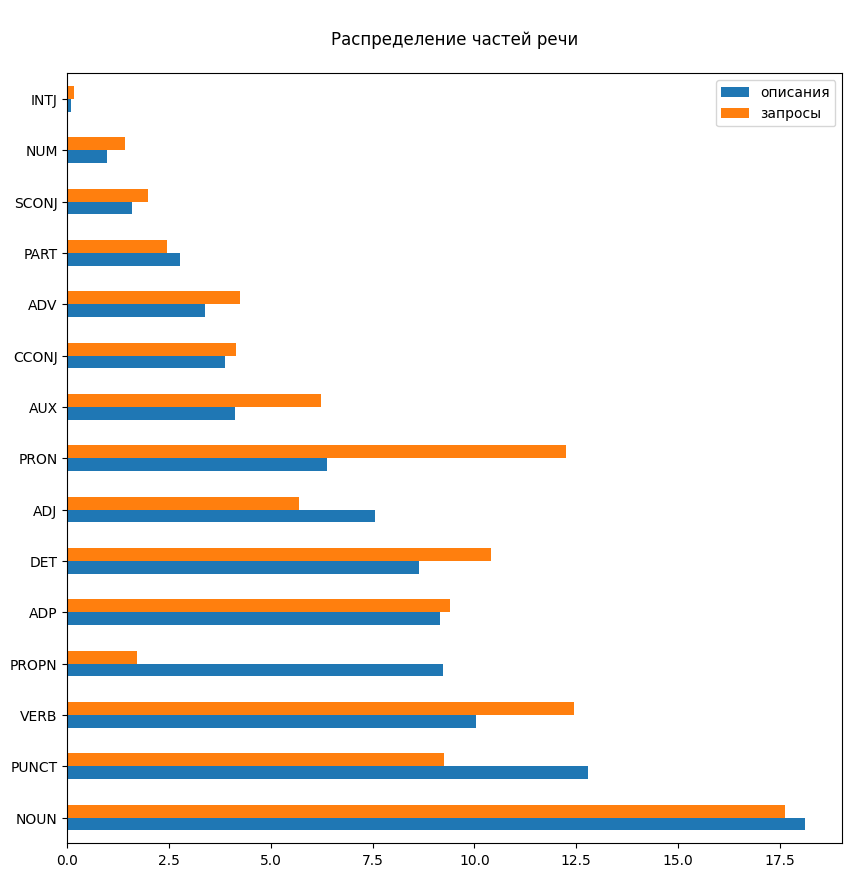

In [ ]:
df_poses = pd.DataFrame.from_dict([poses_books, poses_queries]).transpose()
df_poses.columns = ["описания", "запросы"]
df_poses = df_poses.drop(index=['X', 'SYM', 'SPACE'])
df_poses.plot.barh(title="\nРаспределение частей речи\n", figsize=(10,10))
df_poses

,описания,запросы
acl,0.481444,0.401400
advcl,1.526458,1.473471
advmod,3.974433,4.804278
amod,6.507751,4.087895
appos,1.148679,0.454628
cc,3.879729,4.116700
conj,4.173768,4.034041
dep,1.204483,0.143402
nmod,0.420580,0.288056


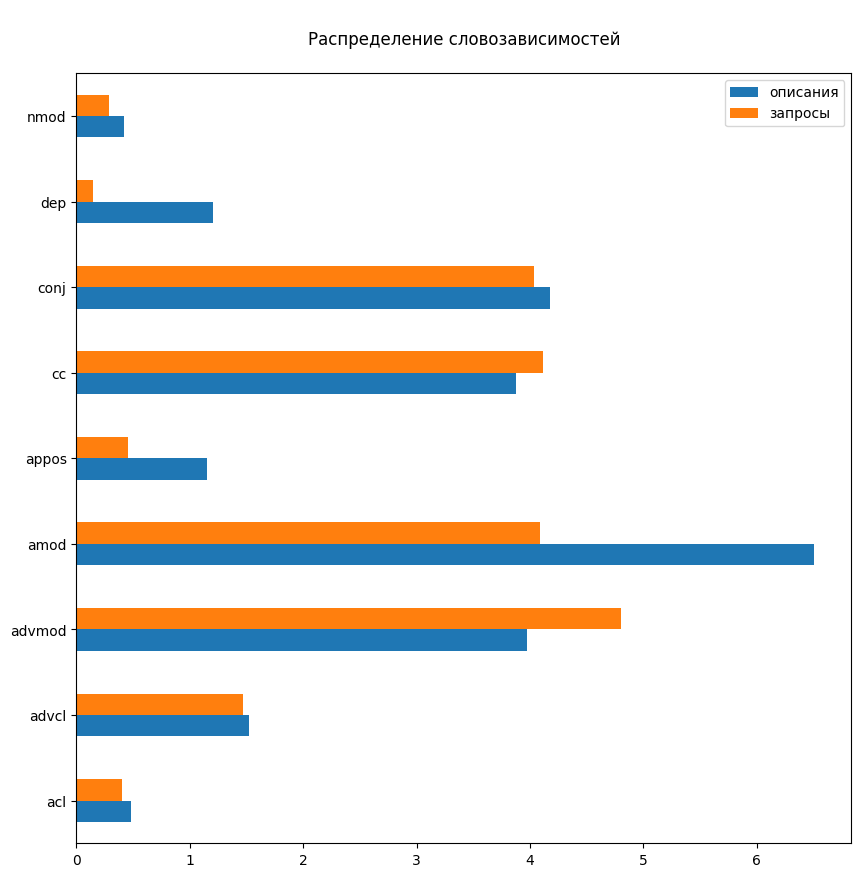

In [ ]:
df_deps = pd.DataFrame.from_dict([deps_books, deps_queries])
df_deps = df_deps[["acl", "advcl", "advmod", "amod", "appos", "cc", "conj", "dep", "nmod"]].transpose()
df_deps.columns = ["описания", "запросы"]
df_deps.plot.barh(title="\nРаспределение словозависимостей\n", figsize=(10,10))
df_deps

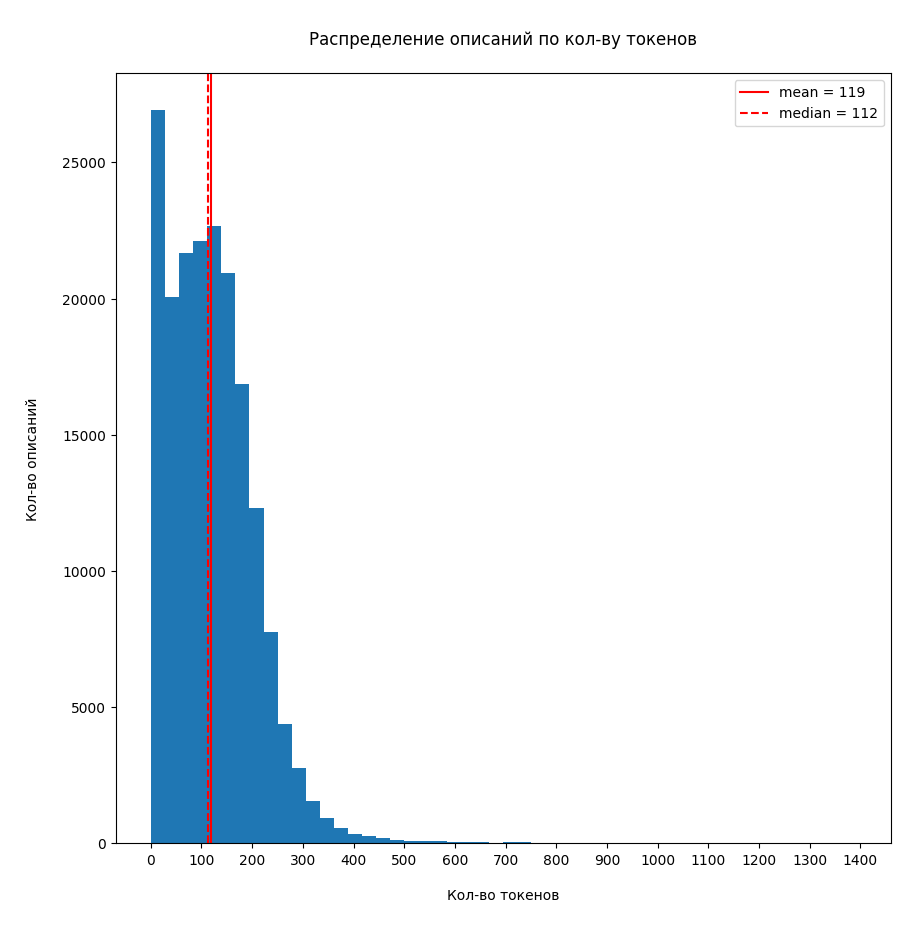

In [ ]:
books_tokens_count = df_books[df_books['tokens_count'] < 1500]['tokens_count']
books_tokens_count.plot.hist(title="\nРаспределение описаний по кол-ву токенов\n", figsize=(10,10), bins=50)
plt.axvline(x=books_tokens_count.mean(), color='r', linestyle='-')
plt.axvline(x=books_tokens_count.median(), color='r', linestyle='--')
plt.xticks(range(0, 1401, 100))
plt.ylabel('\nКол-во описаний\n')
plt.xlabel('\nКол-во токенов\n')
plt.legend(handles=[plt.Line2D([0], [0], linestyle='-', color='r', label=f'mean = {int(books_tokens_count.mean())}'),
                    plt.Line2D([0], [0], linestyle='--', color='r', label=f'median = {int(books_tokens_count.median())}')],
                    loc="upper right")

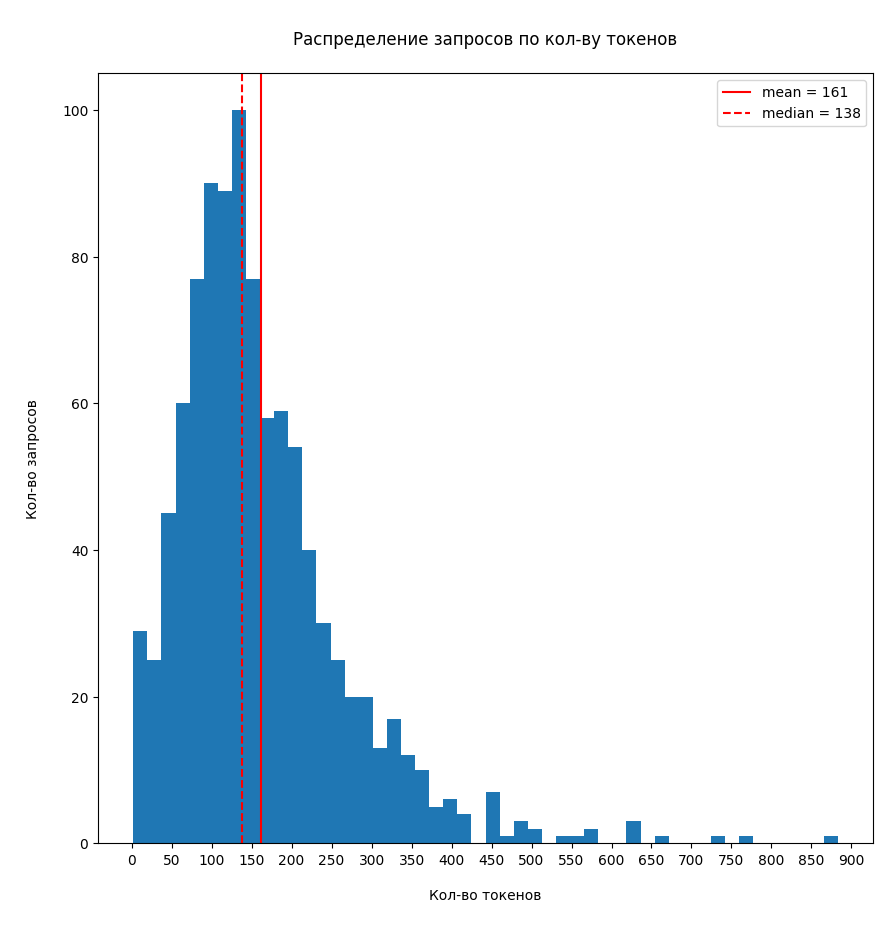

In [ ]:
df_queries['tokens_count'].plot.hist(title="\nРаспределение запросов по кол-ву токенов\n", figsize=(10,10), bins=50)
plt.axvline(x=df_queries['tokens_count'].mean(), color='r', linestyle='-')
plt.axvline(x=df_queries['tokens_count'].median(), color='r', linestyle='--')
plt.xticks(range(0, 901, 50))
plt.ylabel('\nКол-во запросов\n')
plt.xlabel('\nКол-во токенов\n')
plt.legend(handles=[plt.Line2D([0], [0], linestyle='-', color='r', label=f"mean = {int(df_queries['tokens_count'].mean())}"),
                    plt.Line2D([0], [0], linestyle='--', color='r', label=f"median = {int(df_queries['tokens_count'].median())}")],
                    loc="upper right")

In [ ]:
pd.set_option('display.max_colwidth', 1000)
display(df_books[["description", "clean_description"]])
display(df_queries[["query", "clean_query"]])
pd.set_option('display.max_colwidth', 50)

,description,clean_description
0,"Relates in vigorous prose the tale of Aeneas, the legendary ancestor of Romulus, who escaped from the burning city of Troy and wandered the Mediterranean for years before settling in Italy. Patterned after the Iliad and the Odyssey, the Aeneid was composed as an epic poem by Virgil, to glorify the imperial city of Rome.",relate vigorous prose tale Aeneas legendary ancestor Romulus escape burn city Troy wander Mediterranean year settle Italy pattern Iliad Odyssey Aeneid compose epic poem Virgil glorify imperial city Rome
1,"To Kara's astonishment, she discovers that a portal has opened in her bedroom closet and two goblins have fallen through! They refuse to return to the fairy realms and be drafted for an impending war. In an attempt to roust the pesky creatures, Kara falls through the portal, smack into the middle of a huge war. Kara meets Queen Selinda, who appoints Kara as a Fairy Princess and assigns her an impossible task: to put an end to the war using her diplomatic skills.\nAll's Fairy In Love And War is the eighth book in Avalon: Web of Magic, a twelve-book fantasy series for middle grade readers. Through their magical journey, the teenage heroines discover who they really are . . . and run into plenty of good guys, bad guys, and cute guys. Out of print for two years, Seven Seas is pleased to return the Avalon series to print in editions targeted for today's readers, with new manga-style covers and interior illustrations.",Kara astonishment discover portal open bedroom closet goblin fall refuse return fairy realm draft impending war attempt roust pesky creature Kara fall portal smack middle huge war Kara meet Queen Selinda appoint Kara Fairy Princess assign impossible task end war diplomatic skill Fairy Love War eighth book Avalon web Magic book fantasy series middle grade reader magical journey teenage heroine discover run plenty good guy bad guy cute guy print year Seven Seas pleased return Avalon series print edition target today reader new manga style cover interior illustration
2,"In Newbery Medalist Cynthia Rylant's classic bestseller, the author comforts readers young and old who have lost a dog. Recommended highly by pet lovers around the world, Dog Heaven not only comforts but also brings a tear to anyone who is devoted to a pet. From expansive fields where dogs can run and run to delicious biscuits no dog can resist, Rylant paints a warm and affectionate picture of the ideal place God would, of course, create for man's best friend. The first picture book illustrated by the author, Dog Heaven is enhanced by Rylant's bright, bold paintings that perfectly capture an afterlife sure to bring solace to anyone who is grieving.",Newbery Medalist Cynthia Rylant classic bestseller author comfort reader young old lose dog recommend highly pet lover world Dog Heaven comfort bring tear devoted pet expansive field dog run run delicious biscuit dog resist Rylant paint warm affectionate picture ideal place God course create man good friend picture book illustrate author Dog Heaven enhance Rylant bright bold painting perfectly capture afterlife sure bring solace grieve
4,WHAT DO YOU DO?\nA hen lays eggs...\nA cow gives milk...\nAn elephant squirts water...\nBut what does a beetle do?,hen lay egg cow give milk elephant squirt water beetle
5,Ben draws a train that takes him to all sorts of wonderful places before returning him to his own bed.,Ben draw train take sort wonderful place return bed
...,...,...
182930,"When 15 year old Neal Marchal finds her neighbor murdered, she knows who did it. The why is the secret the family has been keeping forever. While Paul took an interest in Neal's musical education and taught her how to play the fiddle, he took her fatherless stepbrother, Joe, under his wing and all that implies. Joe's rage has always been barely beneath the surface and years ago, he pushed Neal under a tractor as a warning. The reminder to never reveal the secret is her limp.\nWhile Jo

,query,clean_query
0,"Memory is really foggy,but still, the book was YA, I read the book in 2016-2017, the author(I'm pretty sure) was a woman, English speaking at that(American I assume) the book was set in modern times.I don't remember the main girls name but she played soccer,and her friends name was (maybe) Zoe. The main girl had a love interest who went by Taz, which was short for either Tazman or Tasmanian, she met the love interest in an antique shop,The main focus of the book was not the romance though. I think the cover was of a a tree on a hill with two girls on it, and the title (MAYBE) had the words ""The book of..."". At one point in the story we follow the main girl as she watches her friend (Zoe/Zoey?) shoplift with a new group of friends she found herself. That's all I can really remember off the top of my head, please help I've so long looking for this book.",memory foggy book ya read book pretty sure woman English speak assume book set modern time remember main girl play soccer friend maybe Zoe main girl love interest go Taz short Tazman Tasmanian meet love interest antique shop main focus book romance think cover tree hill girl title maybe word book point story follow main girl watch friend Zoe Zoey shoplift new group friend find remember head help long look book
1,"Spoiler: One member of the group drops out of the program last minute. This changes the result of the predictions so that when each remaining student watches their possible future (I think they were shown privately, on some kind of reality simulator) a different group member each time had passed away. Also greatly effects the prospective future group dynamics.",spoiler member group drop program minute change result prediction remain student watch possible future think show privately kind reality simulator different group member time pass away greatly effect prospective future group dynamic
2,"I read this book somewhere between 2020 and 2022, and the blurbs on the back described it as a zombie book even though the people weren't exactly zombies. I think the POV switched between the multiple main characters, all of which fled from their homes after everyone around them became seemingly possessed and started attacking them. I don't remember any of the character's names, unfortunately, but I believe the cover was mostly red? The book was also really thick, which is why I wasn't able to finish it in the two weeks I had before returning it to the library. SPOILERS AHEAD.I'm very new to the site, so apologies if I did the spoiler html tag incorrectly.",read book blurb describe zombie book people exactly zombie think POV switch multiple main character flee home seemingly possess start attack remember character name unfortunately believe cover red book thick able finish week return library SPOILERS new site apology spoiler html tag incorrectly
3,"Spoilers here.The character follows the entity around and one of the scenes a high school wrestler bully gets burned at the stake.And other scene is a couple that hits a dog with their car and doesn't help it and I think one of them gets turned into puzzle pieces with the other having to rebuild them in a certain time or they don't live or something like that.It was a very dark book but really well written all the punishments also took place in between seconds so once it was over then everything went back to normal but the people were taught a lesson, can't remember if they could remember it or not or it was just something about punishing their soul I don't know. It had a sequel but I don't remember much about it. Think the person following the entity around then took on their role.",spoiler character follow entity scene high school wrestler bully get burn stake scene couple hit dog car help think get turn puzzle piece have rebuild certain time live like dark book write punishment take place second go normal people teach lesson remember remember punish soul know sequel remember think person follow entity take rol

# Очистка данных

In [9]:
df_books = df_books.dropna()
df_books = df_books[df_books.apply(lambda x: 5 < x['tokens_count'] < 1500, axis=1)].reset_index(drop=True)

df_queries = df_queries.dropna()
df_queries = df_queries[df_queries.apply(lambda x: 5 < x['tokens_count'], axis=1)].reset_index(drop=True)
df_queries = df_queries[df_queries.apply(lambda x: x['book_id'] in list(df_books['book_id']), axis=1)].reset_index(drop=True)

display(df_books)
display(df_queries)

,book_id,title,publication_year,language_code,format,description,url,tokens_count,clean_description
0,287141,The Aeneid for Boys and Girls,2006,,Paperback,"Relates in vigorous prose the tale of Aeneas, ...",https://www.goodreads.com/book/show/287141.The...,61.0,relate vigorous prose tale Aeneas legendary an...
1,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,2009,,Paperback,"To Kara's astonishment, she discovers that a p...",https://www.goodreads.com/book/show/6066812-al...,191.0,Kara astonishment discover portal open bedroom...
2,89378,Dog Heaven,1995,eng,Hardcover,In Newbery Medalist Cynthia Rylant's classic b...,https://www.goodreads.com/book/show/89378.Dog_...,126.0,Newbery Medalist Cynthia Rylant classic bestse...
3,1698376,What Do You Do?,2005,,Board Book,WHAT DO YOU DO?\nA hen lays eggs...\nA cow giv...,https://www.goodreads.com/book/show/1698376.Wh...,31.0,hen lay egg cow give milk elephant squirt wate...
4,2592648,It's Funny Where Ben's Train Takes Him,1999,,Hardcover,Ben draws a train that takes him to all sorts ...,https://www.goodreads.com/book/show/2592648-it...,21.0,Ben draw train take sort wonderful place retur...
...,...,...,...,...,...,...,...,...,...
165238,9568989,Bad Apple,,eng,,When 15 year old Neal Marchal finds her neighb...,https://www.goodreads.com/book/show/9568989-ba...,243.0,year old Neal Marchal find neighbor murder kno...
165239,16373114,"Abandon (Abandon, #1)",2011,eng,Audiobook,Though she tries returning to the life she kne...,https://www.goodreads.com/book/show/16373114-a...,188.0,try return life know accident Pierce help feel...
165240,8987191,"The Mockingbirds (The Mockingbirds, #1)",2010,eng,,Some schools have honor codes.\nOthers have ha...,https://www.goodreads.com/book/show/8987191-th...,133.0,school honor code handbook Themis Academy Mock...
165241,23636536,Another Day,2015,eng,ebook,The eagerly anticipated companion to David Lev...,https://www.goodreads.com/book/show/23636536-a...,214.0,eagerly anticipate companion David Levithan Ne...


,book_id,query,tokens_count,clean_query
0,22718719,"Memory is really foggy,but still, the book was...",204.0,memory foggy book ya read book pretty sure wom...
1,15276080,Spoiler: One member of the group drops out of ...,66.0,spoiler member group drop program minute chang...
2,9342256,I read this book somewhere between 2020 and 20...,132.0,read book blurb describe zombie book people ex...
3,26238686,Spoilers here.The character follows the entity...,163.0,spoiler character follow entity scene high sch...
4,6596581,I read this book a long time ago when I was in...,178.0,read book long time ago elementary school youn...
...,...,...,...,...
858,7931997,Here's what I remember. - The main character i...,191.0,remember main character person narrator mute t...
859,273730,"I associate the word ""dreary"" with this book- ...",53.0,associate word dreary school town remember pat...
860,1422913,I'm looking for a Christmas picture book I rea...,97.0,look Christmas picture book read picture book ...
861,35858102,it said title was too long so: A huge differen...,135.0,say title long huge difference book plot work ...


# Векторайзеры

In [10]:
TOP_K = 10

In [11]:
# https://en.wikipedia.org/wiki/Cosine_similarity
def cos_sim(description_vector, query_vector):
    return ((description_vector @ query_vector) / (norm(description_vector) * norm(query_vector)))

In [12]:
# ПРИМЕР РАБОТЫ
# max_features - Unable to allocate 182. GiB for an array with shape (163224, 149326) and data type float64

vectorizer = TfidfVectorizer(max_features=1500)
query = 'Harry Potter'

X_all = vectorizer.fit_transform(df_books['clean_description']).toarray()
Y = vectorizer.transform([clear(nlp(query))]).toarray().reshape(len(X_all[0]), 1)
simil = []
for X, title, book_id in zip(X_all, df_books['title'], df_books['book_id']):
    simil.append((cos_sim(X, Y), title, book_id))
simil.sort(reverse=True)
simil = simil[:TOP_K]
display(simil)

[(array([0.83815493]), 'Black and Blue Magic', 15830779),
 (array([0.82023985]), 'Harry and the Dinosaurs at the Museum', 1420208),
 (array([0.77188854]), 'Harry and Willy and Carrothead', 2318797),
 (array([0.7624684]),
  'Harry and the Dinosaurs Go To School (Harry and the Dinosaurs)',
  1172526),
 (array([0.76130631]), "Happy Harry's Cafe", 13531036),
 (array([0.73055286]), 'Deep-Sea Disaster', 18689797),
 (array([0.72480677]), 'Black and Blue Magic', 1133359),
 (array([0.72270238]), 'The Boy Scout Aviators', 8436292),
 (array([0.71554873]), "Mr Nobody's Eyes", 28598390),
 (array([0.68954071]), 'Harry dan Geng Keriput', 3784001)]

In [100]:

# Count Vectorizer
# Implementation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
def runCountVectorizer(descriptions: np.array, queries: np.array, features=1500) -> tuple[str, np.array, np.array]:
    vectorizer = CountVectorizer(max_features=features)
    description_vectors = vectorizer.fit_transform(descriptions).toarray()
    queries_vectors = vectorizer.transform(queries).toarray()
    return (f"Count Vectorizer", description_vectors, queries_vectors)


# TF-IDF
# Implementation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
def runTfidfVectorizer(descriptions: np.array, queries: np.array, features=1500) -> tuple[str, np.array, np.array]:
    vectorizer = TfidfVectorizer(max_features=features)
    description_vectors = vectorizer.fit_transform(descriptions).toarray()
    queries_vectors = vectorizer.transform(queries).toarray()
    return (f"TF-IDF Vectorizer", description_vectors, queries_vectors)


# WORD2VEC
# Implementation: https://radimrehurek.com/gensim/models/word2vec.html
def runWord2VecVectorizer(descriptions: np.array, queries: np.array) -> tuple[str, np.array, np.array]:
    vectorizer = Word2Vec([entry.split(" ") for entry in descriptions])
    descriptions_vectors = np.array([vectorizer.wv.get_mean_vector(entry.split(" ")) for entry in descriptions])
    queries_vectors = np.array([vectorizer.wv.get_mean_vector(entry.split(" ")) for entry in queries])
    return ("Word2Vec", descriptions_vectors, queries_vectors)


# DOC2VEC
# Implementation: https://radimrehurek.com/gensim/models/doc2vec.html
def runDoc2VecVectorizer(descriptions: np.array, queries: np.array) -> tuple[str, np.array, np.array]:
    vectorizer = Doc2Vec([TaggedDocument(description.split(" "), [str(i)]) for i, description in enumerate(descriptions)])
    descriptions_vectors = np.array([vectorizer.infer_vector(description.split(" ")) for description in descriptions])
    queries_vectors = np.array([vectorizer.infer_vector(query.split(" ")) for query in queries])
    return ("Doc2Vec", descriptions_vectors, queries_vectors)


# WORD2VEC (Pretrained)
# Implementation: https://radimrehurek.com/gensim/models/word2vec.html
# Data: https://github.com/piskvorky/gensim-data (word2vec-google-news-300)
def runWord2VecPretrainedVectorizer(descriptions: np.array, queries: np.array) -> tuple[str, np.array, np.array]:
    vectorizer = word2vec_pretrained
    descriptions_vectors = np.array([vectorizer.get_mean_vector(entry.split(" ")) for entry in descriptions])
    queries_vectors = np.array([vectorizer.get_mean_vector(entry.split(" ")) for entry in queries])
    return ("Word2Vec (Pretrained)", descriptions_vectors, queries_vectors)


# GloVe (Pretrained)
# Implementation: https://radimrehurek.com/gensim/scripts/glove2word2vec.html 
# Data: https://github.com/piskvorky/gensim-data (glove-twitter-200)
def runGloveVectorizer(descriptions: np.array, queries: np.array) -> tuple[str, np.array, np.array]:
    vectorizer = glove_pretrained
    descriptions_vectors = np.array([vectorizer.get_mean_vector(entry.split(" ")) for entry in descriptions])
    queries_vectors = np.array([vectorizer.get_mean_vector(entry.split(" ")) for entry in queries])
    return ("GloVe (Pretrained)", descriptions_vectors, queries_vectors)   


# SENTENCE TRANSFORMER (Pretrained)
# Implementation: https://www.sbert.net/docs/quickstart.html
# Data: https://www.sbert.net/docs/pretrained_models.html
def runSentenceTransformerVectorizer(descriptions: np.array, queries: np.array) -> tuple[str, np.array, np.array]:
    vectorizer = SentenceTransformer("all-MiniLM-L6-v2")
    return ("Sentence Transformer (Pretrained)", vectorizer.encode(descriptions, convert_to_numpy=True), vectorizer.encode(queries, convert_to_numpy=True))


# ELMO (Pretrained)
# Implementation: https://github.com/ltgoslo/simple_elmo
# Data: http://vectors.nlpl.eu/repository (ID=225) Corpus of Historical American English Embeddings from Language Models (ELMo)
def runElmoVectorizer(descriptions: np.array, queries: np.array) -> tuple[str, np.array, np.array]:
    vectorizer = None
    graph = tensorflow.Graph()
    with graph.as_default() as elmo_graph:
        vectorizer = ElmoModel()
        vectorizer.load("./elmo")
        with elmo_graph.as_default() as current_graph:
            tf_session = tensorflow.compat.v1.Session(graph=current_graph)
            with tf_session.as_default() as sess:
                vectorizer.elmo_sentence_input = simple_elmo.elmo.weight_layers("input", vectorizer.sentence_embeddings_op)
                sess.run(tensorflow.compat.v1.global_variables_initializer())
                    
                descriptions_vectors = vectorizer.get_elmo_vector_average([entry.split(" ") for entry in descriptions], session=tf_session)
                queries_vectors = vectorizer.get_elmo_vector_average([entry.split(" ") for entry in queries], session=tf_session)
                return ("ELMO (Pretrained)", descriptions_vectors, queries_vectors)
        

In [70]:
# https://www.evidentlyai.com/ranking-metrics/mean-reciprocal-rank-mrr

df_vectorizer_compare = pd.DataFrame(columns=['total', 'found', 'accuracy', 'mrr'])
for vectorizer in [runCountVectorizer, runTfidfVectorizer, runWord2VecVectorizer, runDoc2VecVectorizer,
                   runWord2VecPretrainedVectorizer, runGloveVectorizer, runSentenceTransformerVectorizer]:
    
    logger.setLevel(logging.CRITICAL)
    name, descriptions_vectors, queries_vectors = vectorizer(df_books['clean_description'].values, df_queries['clean_query'].values)
    logger.setLevel(logging.DEBUG)

    found = 0
    mrr = 0
    predicted_ids = []
    print(f"{name}:")
    print(f"  shapes: {descriptions_vectors.shape} x {queries_vectors.shape}")

    with tqdm(total=(descriptions_vectors.shape[0]*queries_vectors.shape[0])) as pbar:
        for true_id, query_vector in zip(df_queries['book_id'], queries_vectors):
            predicted_ids.clear()
            for predicted_id, description_vector in zip(df_books['book_id'], descriptions_vectors): 
                predicted_value = cos_sim(description_vector, query_vector)
                predicted_ids.append((predicted_value, predicted_id))
                pbar.update(1)
            predicted_ids.sort(key=lambda x: x[0], reverse=True)
            predicted_ids = predicted_ids[:TOP_K]
            predicted_ids = [x[1] for x in predicted_ids]

            if true_id in predicted_ids:
                found += 1
                mrr += 1 / (predicted_ids.index(true_id) + 1)

    mrr = mrr / len(queries_vectors)
    acc = found / len(queries_vectors)
        
    print(f"  acc: {acc}\n  mrr: {mrr}\n")
    df_vectorizer_compare.loc[name] = [len(queries_vectors), found, acc, mrr]

Count Vectorizer:
  shapes: (165243, 1500) x (863, 1500)


100%|██████████| 142604709/142604709 [17:06<00:00, 138913.62it/s]


  acc: 0.004634994206257242
  mrr: 0.0022531221835972704

TF-IDF Vectorizer:
  shapes: (165243, 1500) x (863, 1500)


100%|██████████| 142604709/142604709 [11:56<00:00, 199165.53it/s]


  acc: 0.005793742757821553
  mrr: 0.0024044032444959446

Word2Vec:
  shapes: (165243, 100) x (863, 100)


100%|██████████| 142604709/142604709 [09:42<00:00, 244609.68it/s]


  acc: 0.009269988412514484
  mrr: 0.002566720005885707

Doc2Vec:
  shapes: (165243, 100) x (863, 100)


100%|██████████| 142604709/142604709 [09:40<00:00, 245523.35it/s]


  acc: 0.006952491309385863
  mrr: 0.0032444959443800694

Word2Vec (Pretrained):
  shapes: (165243, 300) x (863, 300)


100%|██████████| 142604709/142604709 [09:52<00:00, 240549.09it/s]


  acc: 0.009269988412514484
  mrr: 0.006924902058158141

GloVe (Pretrained):
  shapes: (165243, 200) x (863, 200)


100%|██████████| 142604709/142604709 [09:30<00:00, 250005.66it/s]


  acc: 0.006952491309385863
  mrr: 0.002280251613971197

Sentence Transformer (Pretrained):
  shapes: (165243, 384) x (863, 384)


100%|██████████| 142604709/142604709 [09:45<00:00, 243763.11it/s]


  acc: 0.030127462340672075
  mrr: 0.013350898489948314



2024-05-23 01:09:12.863650: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 01:09:12.863959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 01:09:12.863983: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 01:09:12.866632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 01:09:12.866746: I tensorflow/core/common_runtime/gpu/gpu

NotFoundError: Graph execution error:

Detected at node 'bilm/CNN/Conv2D_1' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    File "/tmp/ipykernel_963/170349455.py", line 9, in <module>
    File "/tmp/ipykernel_963/883051077.py", line 73, in runElmoVectorizer
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/elmo_helpers.py", line 203, in load
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 98, in __call__
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 286, in __init__
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 290, in _build
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 399, in _build_word_char_embeddings
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 382, in make_convolutions
Node: 'bilm/CNN/Conv2D_1'
Detected at node 'bilm/CNN/Conv2D_1' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    File "/tmp/ipykernel_963/170349455.py", line 9, in <module>
    File "/tmp/ipykernel_963/883051077.py", line 73, in runElmoVectorizer
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/elmo_helpers.py", line 203, in load
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 98, in __call__
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 286, in __init__
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 290, in _build
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 399, in _build_word_char_embeddings
    File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 382, in make_convolutions
Node: 'bilm/CNN/Conv2D_1'
2 root error(s) found.
  (0) NOT_FOUND: No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 179851408 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node bilm/CNN/Conv2D_1}}]]
	 [[mul_4/_77]]
  (1) NOT_FOUND: No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 179851408 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node bilm/CNN/Conv2D_1}}]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'bilm/CNN/Conv2D_1':
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_963/170349455.py", line 9, in <module>
  File "/tmp/ipykernel_963/883051077.py", line 73, in runElmoVectorizer
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/elmo_helpers.py", line 203, in load
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 98, in __call__
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 286, in __init__
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 290, in _build
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 399, in _build_word_char_embeddings
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/simple_elmo/model.py", line 382, in make_convolutions
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tensorflow/python/ops/nn_ops.py", line 2357, in conv2d_v2
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tensorflow/python/ops/nn_ops.py", line 2464, in conv2d
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1378, in conv2d
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 2652, in _create_op_internal
  File "/home/user/bookfinder/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 1160, in from_node_def


In [104]:
for vectorizer in [runElmoVectorizer]:
    name, descriptions_vectors, queries_vectors = vectorizer(df_books['clean_description'].values, df_queries['clean_query'].values)

    found = 0
    mrr = 0
    predicted_ids = []
    print(f"{name}:")
    print(f"  shapes: {descriptions_vectors.shape} x {queries_vectors.shape}")

    with tqdm(total=(descriptions_vectors.shape[0]*queries_vectors.shape[0])) as pbar:
        for true_id, query_vector in zip(df_queries['book_id'], queries_vectors):
            predicted_ids.clear()
            for predicted_id, description_vector in zip(df_books['book_id'], descriptions_vectors): 
                predicted_value = cos_sim(description_vector, query_vector)
                predicted_ids.append((predicted_value, predicted_id))
                pbar.update(1)
            predicted_ids.sort(key=lambda x: x[0], reverse=True)
            predicted_ids = predicted_ids[:TOP_K]
            predicted_ids = [x[1] for x in predicted_ids]

            if true_id in predicted_ids:
                found += 1
                mrr += 1 / (predicted_ids.index(true_id) + 1)

    mrr = mrr / len(queries_vectors)
    acc = found / len(queries_vectors)
        
    print(f"  acc: {acc}\n  mrr: {mrr}\n")
    df_vectorizer_compare.loc[name] = [len(queries_vectors), found, acc, mrr]

2024-05-23 03:09:06.876328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 03:09:06.876398: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 03:09:06.876420: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 03:09:07.061790: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 03:09:07.061832: I tensorflow/core/common_runtime/gpu/gpu

: 

In [71]:
df_vectorizer_compare

,total,found,accuracy,mrr
Count Vectorizer,863.0,4.0,0.004635,0.002253
TF-IDF Vectorizer,863.0,5.0,0.005794,0.002404
Word2Vec,863.0,8.0,0.009270,0.002567
Doc2Vec,863.0,6.0,0.006952,0.003244
Word2Vec (Pretrained),863.0,8.0,0.009270,0.006925
GloVe (Pretrained),863.0,6.0,0.006952,0.002280
Sentence Transformer (Pretrained),863.0,26.0,0.030127,0.013351


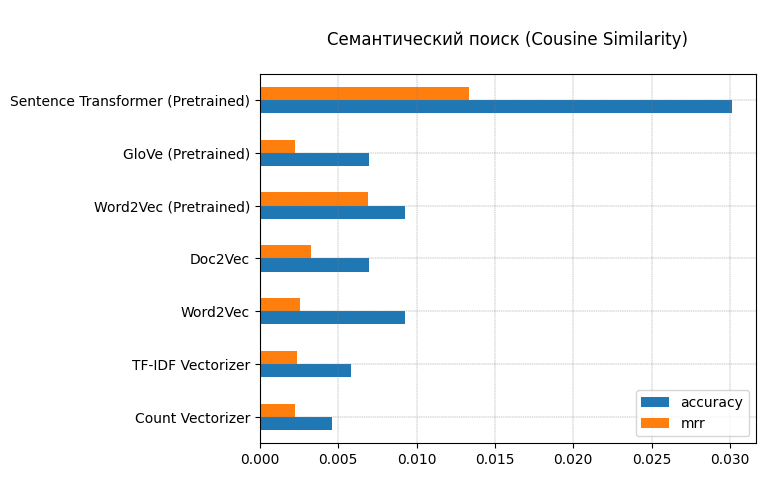

In [72]:
df_vectorizer_compare[['accuracy', 'mrr']].plot.barh(title="\nСемантический поиск (Cousine Similarity)\n")
plt.grid(True, color = "grey", linewidth = "0.3", linestyle = "--")

# Нейронная сеть

In [21]:
# Подготовка датасета (комбинации запросов и описаний)
true_data = df_queries[['book_id', 'clean_query']].copy()
true_data['clean_description'] = true_data['book_id'].map(lambda x: df_books.loc[df_books['book_id'] == x]['clean_description'].values[0])
true_data['result'] = [1.0 for _ in range(len(true_data))]

# Добавим случайных данных
random_descriptions = df_books['clean_description'].sample(len(true_data), replace=True).reset_index(drop=True)
random_queries = df_queries['clean_query'].sample(len(true_data), replace=True).reset_index(drop=True)
random_data = random_descriptions.to_frame().join(random_queries)
random_data['result'] = [0.0 for _ in range(len(random_data))]

data = pd.concat([true_data, random_data])
data = data.sample(frac=1)
display(data['result'].value_counts())
display(data)

result
1.0    863
0.0    863
Name: count, dtype: int64

,book_id,clean_query,clean_description,result
92,2650003.0,read ish set UK probably London mother mentall...,mother hospitalize suffer mental breakdown sev...,1.0
518,7986212.0,sure actually graphic novel remember lot black...,Memory Bankis story Hope Scroggins live belove...,1.0
123,847947.0,ok read book long time ago orphan boy live New...,parent die Jeffrey Lionel Magee life legendary...,1.0
425,28436751.0,book woman friend online bond fandom buddy cop...,story follow unlikely friendship young woman f...,1.0
326,NaN,read early believe girl good friend Corrine Ch...,Gil ant think friend forget special day plan s...,0.0
...,...,...,...,...
117,NaN,read book think pretty new time read believe m...,VENGEANCE Allison Sekemoto struggle question h...,0.0
844,1175829.0,novel English country origin United States Can...,fight truck barrel Wenny lose big Wenny lose l...,1.0
358,NaN,memory old life eventually realize happen end ...,Wolf Big Feet story series intend audience age...,0.0
671,3324186.0,read child book early suspect write boy guess ...,Gunno gang break Big House find life change Gu...,1.0


Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_79 (InputLayer)       [(None, 1000)]               0         []                            
                                                                                                  
 input_80 (InputLayer)       [(None, 1000)]               0         []                            
                                                                                                  
 concatenate_39 (Concatenat  (None, 2000)                 0         ['input_79[0][0]',            
 e)                                                                  'input_80[0][0]']            
                                                                                                  
 dense_169 (Dense)           (None, 2048)                 4098048   ['concatenate_39[0][0]'

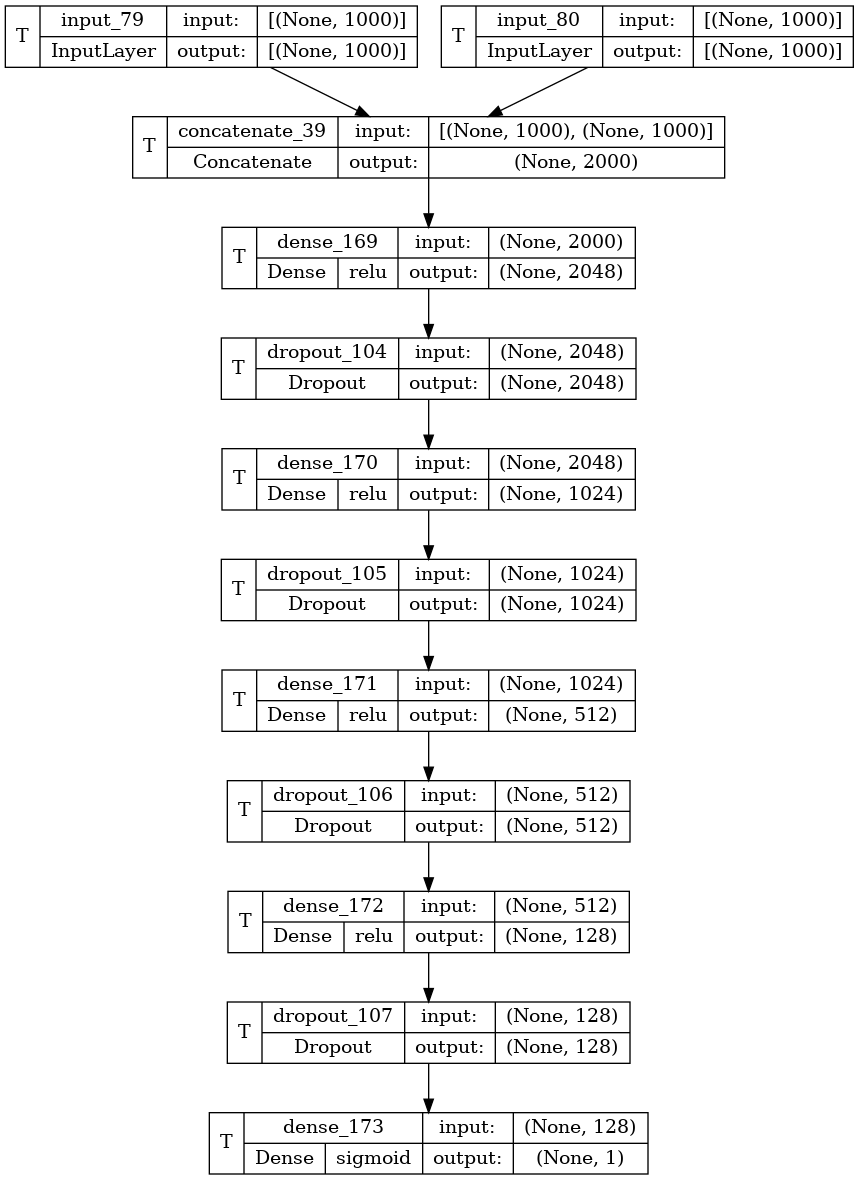

In [67]:
def create_model(input_shape):
    book_input = Input((input_shape,))
    query_input = Input((input_shape,))
    concat_layer = Concatenate()([book_input, query_input])
    dense = Dense(2048, activation="relu")(concat_layer)
    dense = Dropout(0.2)(dense)
    dense = Dense(1024, activation="relu")(dense)
    dense = Dropout(0.15)(dense)
    dense = Dense(512, activation="relu")(dense)
    dense = Dropout(0.1)(dense)
    dense = Dense(128, activation="relu")(dense)
    dense = Dropout(0.08)(dense)
    output_value = Dense(1, activation="sigmoid")(dense)

    model = Model(inputs=[book_input, query_input], outputs=output_value)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model(1000)
model.summary()
plot_model(model, show_shapes=True, show_layer_activations=True, show_trainable=True)

In [68]:
df_nn_compare = pd.DataFrame(columns=['train_accuracy', 'train_loss', 'val_accuracy', 'val_loss'])
for vectorizer in [runCountVectorizer, runTfidfVectorizer, runWord2VecVectorizer, runDoc2VecVectorizer, runWord2VecPretrainedVectorizer, runGloveVectorizer, runSentenceTransformerVectorizer, runElmoVectorizer]:

    logger.setLevel(logging.CRITICAL)
    name, descriptions_vectors, queries_vectors = vectorizer(data['clean_description'].values, data['clean_query'].values)
    logger.setLevel(logging.DEBUG)
    
    descriptions_vectors = descriptions_vectors.astype(np.float32)
    queries_vectors = queries_vectors.astype(np.float32)
    results = data['result'].values.astype(np.float32)

    print(f"{name}:")
    model = create_model(descriptions_vectors.shape[1])
    history = model.fit([descriptions_vectors, queries_vectors], results, batch_size=64, epochs=50, verbose=1, validation_split=0.2)
    df_nn_compare.loc[name] = [history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss']]

    del model
    gc.collect()

Count Vectorizer:
Train on 1380 samples, validate on 346 samples


2024-05-22 23:26:23.629481: W tensorflow/c/c_api.cc:305] Operation '{name:'training_52/Adam/beta_1/Assign' id:18361 op device:{requested: '', assigned: ''} def:{{{node training_52/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_52/Adam/beta_1, training_52/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
1216/1380 [=========================>....] - ETA: 0s - loss: 0.7102 - accuracy: 0.5197

2024-05-22 23:26:25.333175: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_40/mul' id:18206 op device:{requested: '', assigned: ''} def:{{{node loss_40/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_40/mul/x, loss_40/dense_178_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1380/1380 [==============================] - 1s 952us/sample - loss: 0.7119 - accuracy: 0.5196 - val_loss: 0.6866 - val_accuracy: 0.5520
Epoch 2/50
1380/1380 [==============================] - 0s 124us/sample - loss: 0.5167 - accuracy: 0.7616 - val_loss: 1.0595 - val_accuracy: 0.5289
Epoch 3/50
1380/1380 [==============================] - 0s 123us/sample - loss: 0.2391 - accuracy: 0.9203 - val_loss: 1.3090 - val_accuracy: 0.5434
Epoch 4/50
1380/1380 [==============================] - 0s 118us/sample - loss: 0.0852 - accuracy: 0.9732 - val_loss: 2.4324 - val_accuracy: 0.4884
Epoch 5/50
1380/1380 [==============================] - 0s 122us/sample - loss: 0.1069 - accuracy: 0.9630 - val_loss: 1.4572 - val_accuracy: 0.5491
Epoch 6/50
1380/1380 [==============================] - 0s 126us/sample - loss: 0.0614 - accuracy: 0.9862 - val_loss: 2.0941 - val_accuracy: 0.5636
Epoch 7/50
1380/1380 [==============================] - 0s 128us/sample - loss: 0.0264 - accuracy: 0.9928 - val_loss: 2.502

2024-05-22 23:26:36.529108: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_180/kernel/Assign' id:18659 op device:{requested: '', assigned: ''} def:{{{node dense_180/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_180/kernel, dense_180/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
1152/1380 [========================>.....] - ETA: 0s - loss: 0.6923 - accuracy: 0.5078

2024-05-22 23:26:38.066044: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_41/mul' id:18828 op device:{requested: '', assigned: ''} def:{{{node loss_41/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_41/mul/x, loss_41/dense_183_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1380/1380 [==============================] - 1s 955us/sample - loss: 0.6918 - accuracy: 0.5203 - val_loss: 0.6832 - val_accuracy: 0.5636
Epoch 2/50
1380/1380 [==============================] - 0s 122us/sample - loss: 0.4613 - accuracy: 0.8239 - val_loss: 0.9312 - val_accuracy: 0.5145
Epoch 3/50
1380/1380 [==============================] - 0s 122us/sample - loss: 0.0931 - accuracy: 0.9674 - val_loss: 1.8950 - val_accuracy: 0.5405
Epoch 4/50
1380/1380 [==============================] - 0s 121us/sample - loss: 0.0069 - accuracy: 0.9971 - val_loss: 2.5208 - val_accuracy: 0.5289
Epoch 5/50
1380/1380 [==============================] - 0s 122us/sample - loss: 8.2078e-04 - accuracy: 1.0000 - val_loss: 2.7714 - val_accuracy: 0.5260
Epoch 6/50
1380/1380 [==============================] - 0s 124us/sample - loss: 6.2338e-04 - accuracy: 1.0000 - val_loss: 2.8166 - val_accuracy: 0.5694
Epoch 7/50
1380/1380 [==============================] - 0s 125us/sample - loss: 6.9996e-04 - accuracy: 0.9993 - val

2024-05-22 23:26:49.957793: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_184/kernel/Assign' id:19234 op device:{requested: '', assigned: ''} def:{{{node dense_184/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_184/kernel, dense_184/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
1280/1380 [==========================>...] - ETA: 0s - loss: 0.7010 - accuracy: 0.4930

2024-05-22 23:26:51.405025: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_42/mul' id:19438 op device:{requested: '', assigned: ''} def:{{{node loss_42/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_42/mul/x, loss_42/dense_188_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1380/1380 [==============================] - 1s 869us/sample - loss: 0.7007 - accuracy: 0.4913 - val_loss: 0.6925 - val_accuracy: 0.5260
Epoch 2/50
1380/1380 [==============================] - 0s 116us/sample - loss: 0.6940 - accuracy: 0.5022 - val_loss: 0.6930 - val_accuracy: 0.5260
Epoch 3/50
1380/1380 [==============================] - 0s 120us/sample - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.6941 - val_accuracy: 0.4740
Epoch 4/50
1380/1380 [==============================] - 0s 120us/sample - loss: 0.6937 - accuracy: 0.4906 - val_loss: 0.6939 - val_accuracy: 0.4740
Epoch 5/50
1380/1380 [==============================] - 0s 113us/sample - loss: 0.6934 - accuracy: 0.4906 - val_loss: 0.6942 - val_accuracy: 0.4740
Epoch 6/50
1380/1380 [==============================] - 0s 112us/sample - loss: 0.6933 - accuracy: 0.5043 - val_loss: 0.6946 - val_accuracy: 0.4740
Epoch 7/50
1380/1380 [==============================] - 0s 119us/sample - loss: 0.6933 - accuracy: 0.5065 - val_loss: 0.694

2024-05-22 23:27:05.274370: W tensorflow/c/c_api.cc:305] Operation '{name:'training_58/Adam/dense_192/kernel/m/Assign' id:20265 op device:{requested: '', assigned: ''} def:{{{node training_58/Adam/dense_192/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_58/Adam/dense_192/kernel/m, training_58/Adam/dense_192/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
1344/1380 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5238

2024-05-22 23:27:06.767968: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_43/mul' id:20048 op device:{requested: '', assigned: ''} def:{{{node loss_43/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_43/mul/x, loss_43/dense_193_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1380/1380 [==============================] - 1s 979us/sample - loss: 0.6927 - accuracy: 0.5217 - val_loss: 0.6804 - val_accuracy: 0.5983
Epoch 2/50
1380/1380 [==============================] - 0s 159us/sample - loss: 0.6872 - accuracy: 0.5449 - val_loss: 0.6702 - val_accuracy: 0.6301
Epoch 3/50
1380/1380 [==============================] - 0s 152us/sample - loss: 0.6837 - accuracy: 0.5500 - val_loss: 0.6658 - val_accuracy: 0.6040
Epoch 4/50
1380/1380 [==============================] - 0s 151us/sample - loss: 0.6806 - accuracy: 0.5609 - val_loss: 0.6681 - val_accuracy: 0.6387
Epoch 5/50
1380/1380 [==============================] - 0s 149us/sample - loss: 0.6821 - accuracy: 0.5652 - val_loss: 0.6636 - val_accuracy: 0.6301
Epoch 6/50
1380/1380 [==============================] - 0s 150us/sample - loss: 0.6743 - accuracy: 0.5659 - val_loss: 0.6600 - val_accuracy: 0.6301
Epoch 7/50
1380/1380 [==============================] - 0s 149us/sample - loss: 0.6753 - accuracy: 0.5688 - val_loss: 0.681

2024-05-22 23:27:19.160816: W tensorflow/c/c_api.cc:305] Operation '{name:'training_60/Adam/dense_194/kernel/v/Assign' id:20897 op device:{requested: '', assigned: ''} def:{{{node training_60/Adam/dense_194/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_60/Adam/dense_194/kernel/v, training_60/Adam/dense_194/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
1216/1380 [=========================>....] - ETA: 0s - loss: 0.6919 - accuracy: 0.5263

2024-05-22 23:27:21.021556: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_44/mul' id:20658 op device:{requested: '', assigned: ''} def:{{{node loss_44/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_44/mul/x, loss_44/dense_198_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1380/1380 [==============================] - 1s 990us/sample - loss: 0.6927 - accuracy: 0.5225 - val_loss: 0.6818 - val_accuracy: 0.6561
Epoch 2/50
1380/1380 [==============================] - 0s 117us/sample - loss: 0.6679 - accuracy: 0.5775 - val_loss: 0.6661 - val_accuracy: 0.6012
Epoch 3/50
1380/1380 [==============================] - 0s 114us/sample - loss: 0.6301 - accuracy: 0.6543 - val_loss: 0.6551 - val_accuracy: 0.6185
Epoch 4/50
1380/1380 [==============================] - 0s 113us/sample - loss: 0.6220 - accuracy: 0.6457 - val_loss: 0.7828 - val_accuracy: 0.5405
Epoch 5/50
1380/1380 [==============================] - 0s 117us/sample - loss: 0.6240 - accuracy: 0.6638 - val_loss: 0.6515 - val_accuracy: 0.6243
Epoch 6/50
1380/1380 [==============================] - 0s 118us/sample - loss: 0.5913 - accuracy: 0.6819 - val_loss: 0.6566 - val_accuracy: 0.6387
Epoch 7/50
1380/1380 [==============================] - 0s 116us/sample - loss: 0.5596 - accuracy: 0.7203 - val_loss: 0.758

2024-05-22 23:27:31.939757: W tensorflow/c/c_api.cc:305] Operation '{name:'training_62/Adam/dense_199/bias/m/Assign' id:21452 op device:{requested: '', assigned: ''} def:{{{node training_62/Adam/dense_199/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_62/Adam/dense_199/bias/m, training_62/Adam/dense_199/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
1024/1380 [=====================>........] - ETA: 0s - loss: 0.6951 - accuracy: 0.5029

2024-05-22 23:27:33.347953: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_45/mul' id:21268 op device:{requested: '', assigned: ''} def:{{{node loss_45/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_45/mul/x, loss_45/dense_203_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1380/1380 [==============================] - 1s 849us/sample - loss: 0.6947 - accuracy: 0.5036 - val_loss: 0.6947 - val_accuracy: 0.4740
Epoch 2/50
1380/1380 [==============================] - 0s 118us/sample - loss: 0.6833 - accuracy: 0.5333 - val_loss: 0.6675 - val_accuracy: 0.6185
Epoch 3/50
1380/1380 [==============================] - 0s 121us/sample - loss: 0.6473 - accuracy: 0.6174 - val_loss: 0.6613 - val_accuracy: 0.6098
Epoch 4/50
1380/1380 [==============================] - 0s 115us/sample - loss: 0.6157 - accuracy: 0.6551 - val_loss: 0.7068 - val_accuracy: 0.6098
Epoch 5/50
1380/1380 [==============================] - 0s 115us/sample - loss: 0.6024 - accuracy: 0.6616 - val_loss: 0.7023 - val_accuracy: 0.5491
Epoch 6/50
1380/1380 [==============================] - 0s 119us/sample - loss: 0.6008 - accuracy: 0.6594 - val_loss: 0.7099 - val_accuracy: 0.6012
Epoch 7/50
1380/1380 [==============================] - 0s 115us/sample - loss: 0.5566 - accuracy: 0.6971 - val_loss: 0.745

2024-05-22 23:27:46.247108: W tensorflow/c/c_api.cc:305] Operation '{name:'training_64/Adam/dense_204/kernel/v/Assign' id:22117 op device:{requested: '', assigned: ''} def:{{{node training_64/Adam/dense_204/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_64/Adam/dense_204/kernel/v, training_64/Adam/dense_204/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
 960/1380 [===================>..........] - ETA: 0s - loss: 0.6957 - accuracy: 0.5146

2024-05-22 23:27:47.664450: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_46/mul' id:21878 op device:{requested: '', assigned: ''} def:{{{node loss_46/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_46/mul/x, loss_46/dense_208_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1380/1380 [==============================] - 1s 878us/sample - loss: 0.6955 - accuracy: 0.5109 - val_loss: 0.6838 - val_accuracy: 0.5462
Epoch 2/50
1380/1380 [==============================] - 0s 136us/sample - loss: 0.6444 - accuracy: 0.6384 - val_loss: 0.6405 - val_accuracy: 0.6127
Epoch 3/50
1380/1380 [==============================] - 0s 135us/sample - loss: 0.5448 - accuracy: 0.7283 - val_loss: 0.6910 - val_accuracy: 0.6040
Epoch 4/50
1380/1380 [==============================] - 0s 134us/sample - loss: 0.4171 - accuracy: 0.8130 - val_loss: 0.7942 - val_accuracy: 0.6272
Epoch 5/50
1380/1380 [==============================] - 0s 132us/sample - loss: 0.2381 - accuracy: 0.9087 - val_loss: 1.1123 - val_accuracy: 0.6301
Epoch 6/50
1380/1380 [==============================] - 0s 135us/sample - loss: 0.1455 - accuracy: 0.9449 - val_loss: 1.4312 - val_accuracy: 0.5751
Epoch 7/50
1380/1380 [==============================] - 0s 136us/sample - loss: 0.1085 - accuracy: 0.9616 - val_loss: 1.340

2024-05-22 23:27:59.048241: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 23:27:59.048311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 23:27:59.048332: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 23:27:59.048554: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 23:27:59.048565: I tensorflow/core/common_runtime/gpu/gpu

ELMO (Pretrained):
Train on 1380 samples, validate on 346 samples


2024-05-22 23:29:38.969096: W tensorflow/c/c_api.cc:305] Operation '{name:'training_66/Adam/beta_1/Assign' id:22643 op device:{requested: '', assigned: ''} def:{{{node training_66/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_66/Adam/beta_1, training_66/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
1344/1380 [============================>.] - ETA: 0s - loss: 0.6973 - accuracy: 0.5193

2024-05-22 23:29:40.752955: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_47/mul' id:22488 op device:{requested: '', assigned: ''} def:{{{node loss_47/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_47/mul/x, loss_47/dense_213_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1380/1380 [==============================] - 1s 1ms/sample - loss: 0.6970 - accuracy: 0.5217 - val_loss: 0.6896 - val_accuracy: 0.4827
Epoch 2/50
1380/1380 [==============================] - 0s 232us/sample - loss: 0.6808 - accuracy: 0.5601 - val_loss: 0.6681 - val_accuracy: 0.5896
Epoch 3/50
1380/1380 [==============================] - 0s 205us/sample - loss: 0.6707 - accuracy: 0.5848 - val_loss: 0.6489 - val_accuracy: 0.6358
Epoch 4/50
1380/1380 [==============================] - 0s 125us/sample - loss: 0.6394 - accuracy: 0.6217 - val_loss: 0.6621 - val_accuracy: 0.6069
Epoch 5/50
1380/1380 [==============================] - 0s 127us/sample - loss: 0.6168 - accuracy: 0.6500 - val_loss: 0.7055 - val_accuracy: 0.5809
Epoch 6/50
1380/1380 [==============================] - 0s 119us/sample - loss: 0.6116 - accuracy: 0.6565 - val_loss: 0.6675 - val_accuracy: 0.5983
Epoch 7/50
1380/1380 [==============================] - 0s 125us/sample - loss: 0.5961 - accuracy: 0.6754 - val_loss: 0.6643 

In [58]:
df_nn_compare

,train_accuracy,train_loss,val_accuracy,val_loss
Count Vectorizer,"[0.4942029118537903, 0.530434787273407, 0.5239...","[0.8313589120256728, 0.7359667080036109, 0.717...","[0.47398844361305237, 0.5289017558097839, 0.54...","[0.7026229159680405, 0.6888175927145632, 0.690..."
TF-IDF Vectorizer,"[0.5137681365013123, 0.5050724744796753, 0.547...","[0.698168911450151, 0.7058714168659155, 0.6862...","[0.52601158618927, 0.4768786132335663, 0.56069...","[0.6914848833414861, 0.6936025571271863, 0.689..."
Word2Vec,"[0.4884057939052582, 0.5007246136665344, 0.499...","[0.7256458773129228, 0.6972493600154268, 0.696...","[0.5289017558097839, 0.52601158618927, 0.47398...","[0.6930024685887243, 0.6929179743535256, 0.693..."
Doc2Vec,"[0.49637681245803833, 0.5101449489593506, 0.49...","[0.7059585915095564, 0.6983177727547245, 0.698...","[0.5462427735328674, 0.6069363951683044, 0.575...","[0.6907114507145964, 0.6905104349114303, 0.690..."
Word2Vec (Pretrained),"[0.508695662021637, 0.5137681365013123, 0.4985...","[0.7062476888946865, 0.6977002665616464, 0.697...","[0.47398844361305237, 0.52601158618927, 0.5693...","[0.6949310475002134, 0.6917731551765707, 0.692..."
GloVe (Pretrained),"[0.510869562625885, 0.5101449489593506, 0.5108...","[0.7042036583458168, 0.7009139992188717, 0.696...","[0.47398844361305237, 0.47398844361305237, 0.4...","[0.6955671603279996, 0.6933257297284341, 0.692..."
Sentence Transformer (Pretrained),"[0.49130433797836304, 0.5181159377098083, 0.52...","[0.7168947076451951, 0.7012881868127464, 0.691...","[0.5953757166862488, 0.5751445293426514, 0.528...","[0.689486526684954, 0.6879358553472971, 0.6857..."
ELMO (Pretrained),"[0.48188406229019165, 0.4884057939052582, 0.49...","[0.74416469456493, 0.70155986374703, 0.6967237...","[0.52601158618927, 0.52601158618927, 0.4739884...","[0.6920274633892699, 0.6922423305539037, 0.693..."


In [84]:
df_nn_compare['val_accuracy'].apply(lambda x: max(x))

Count Vectorizer                     0.575145
TF-IDF Vectorizer                    0.569364
Word2Vec                             0.526012
Doc2Vec                              0.650289
Word2Vec (Pretrained)                0.658960
GloVe (Pretrained)                   0.653179
Sentence Transformer (Pretrained)    0.647399
ELMO (Pretrained)                    0.644509
Name: val_accuracy, dtype: float64

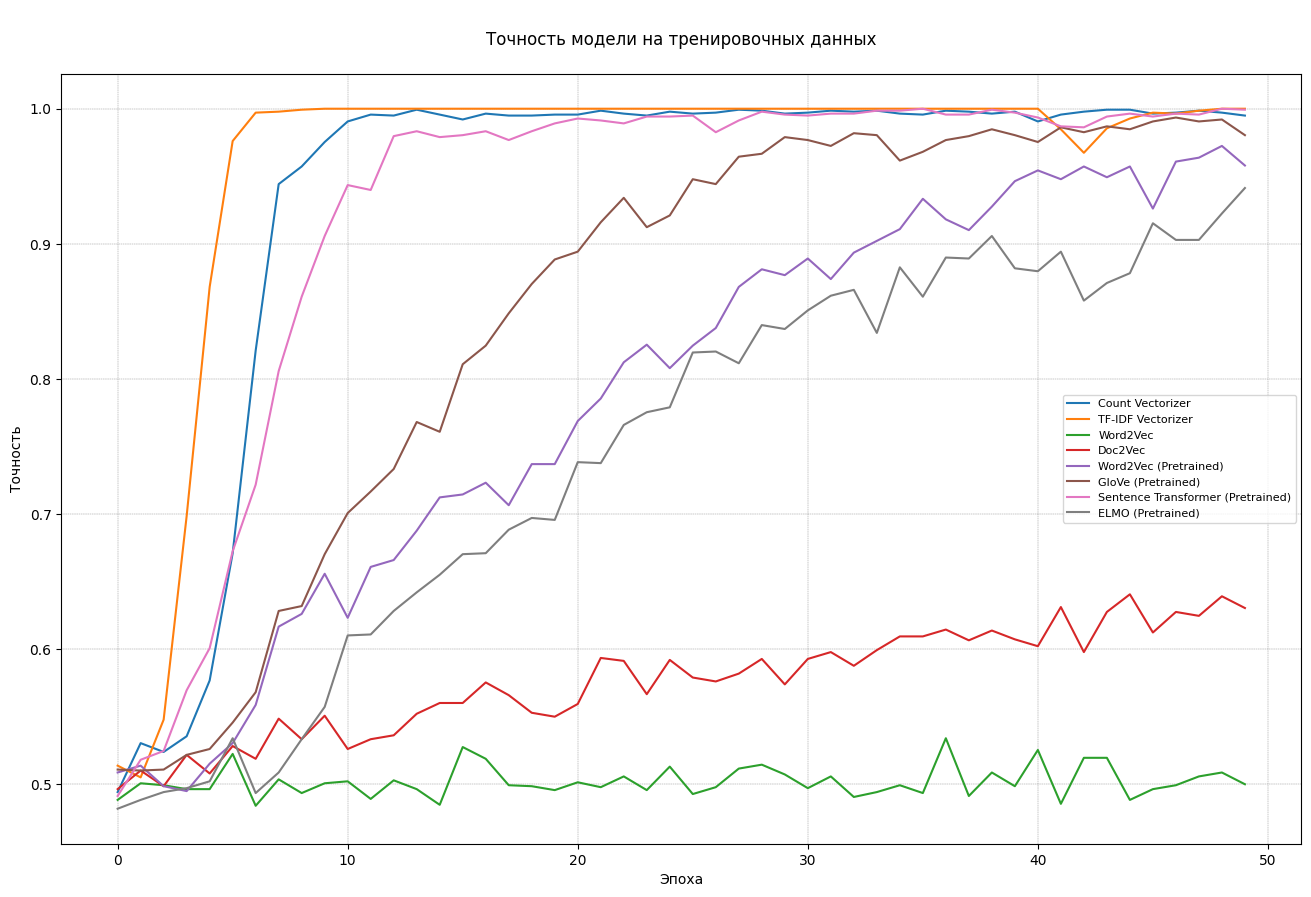

In [63]:
plt.figure(figsize=(16, 10))
for vectorizer in df_nn_compare.index.to_list():
    plt.plot(df_nn_compare['train_accuracy'][vectorizer])
plt.title('\nТочность модели на тренировочных данных\n')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.grid(True, color = "grey", linewidth = "0.3", linestyle = "--")
plt.legend(df_nn_compare.index.to_list(), loc='center right', prop={'size': 8})

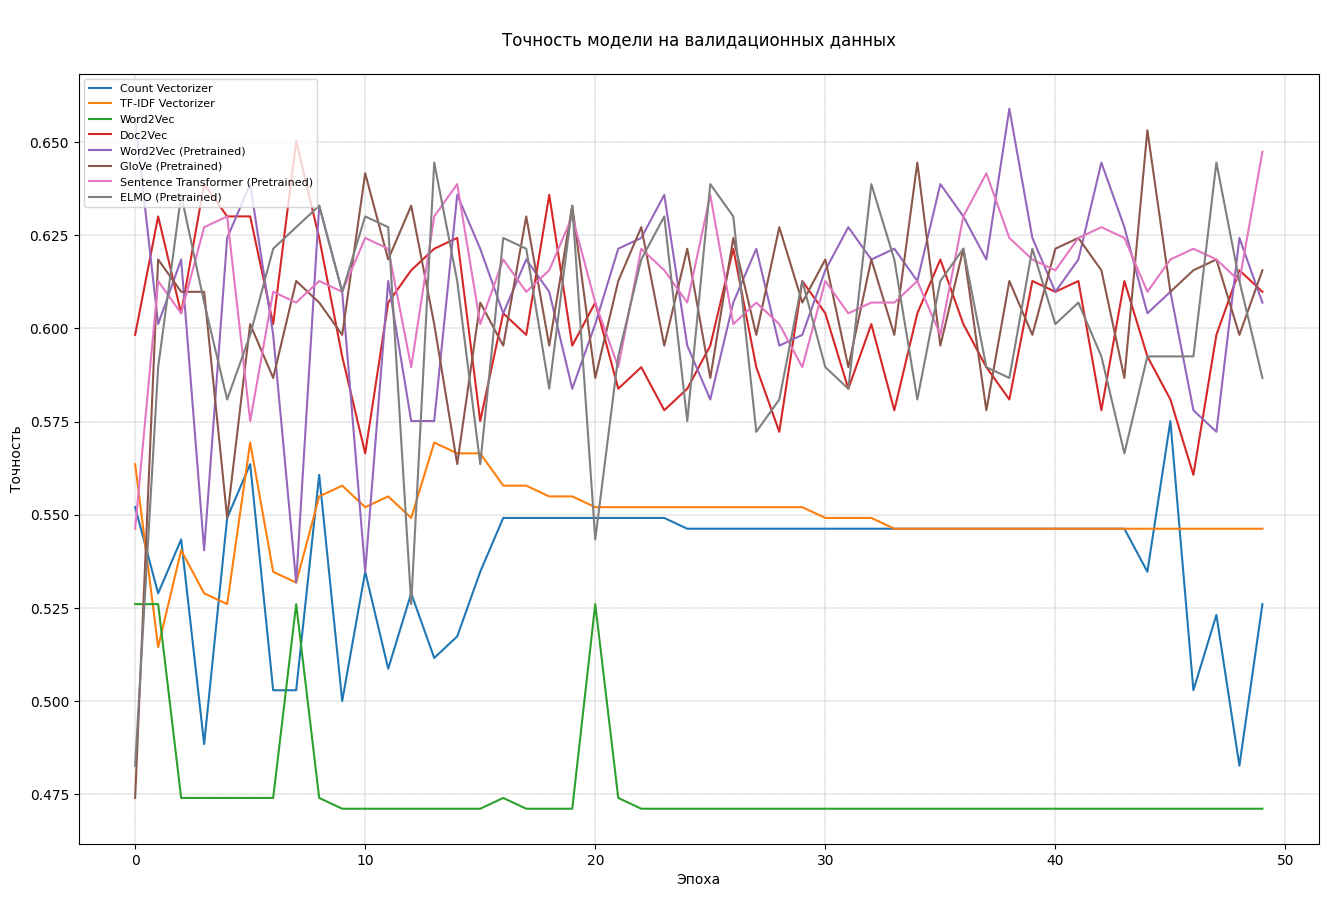

In [69]:
plt.figure(figsize=(16, 10))
for vectorizer in df_nn_compare.index.to_list():
    plt.plot(df_nn_compare['val_accuracy'][vectorizer])
plt.title('\nТочность модели на валидационных данных\n')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.grid(True, color = "grey", linewidth = "0.3", linestyle = "--")
plt.legend(df_nn_compare.index.to_list(), loc='upper left', prop={'size': 8})

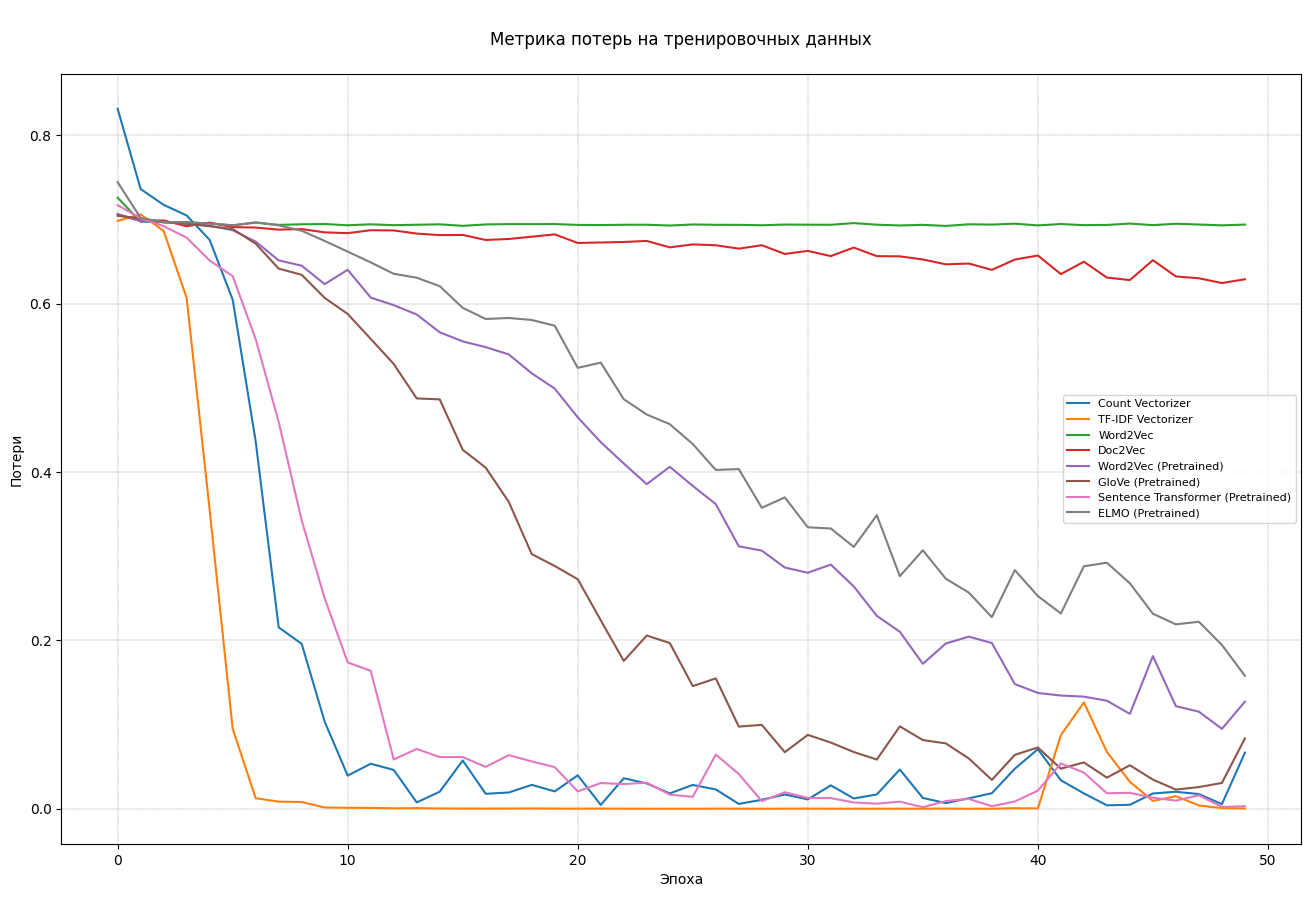

In [65]:
plt.figure(figsize=(16, 10))
for vectorizer in df_nn_compare.index.to_list():
    plt.plot(df_nn_compare['train_loss'][vectorizer])
plt.title('\nМетрика потерь на тренировочных данных\n')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.grid(True, color = "grey", linewidth = "0.3", linestyle = "--")
plt.legend(df_nn_compare.index.to_list(), loc='center right', prop={'size': 8})

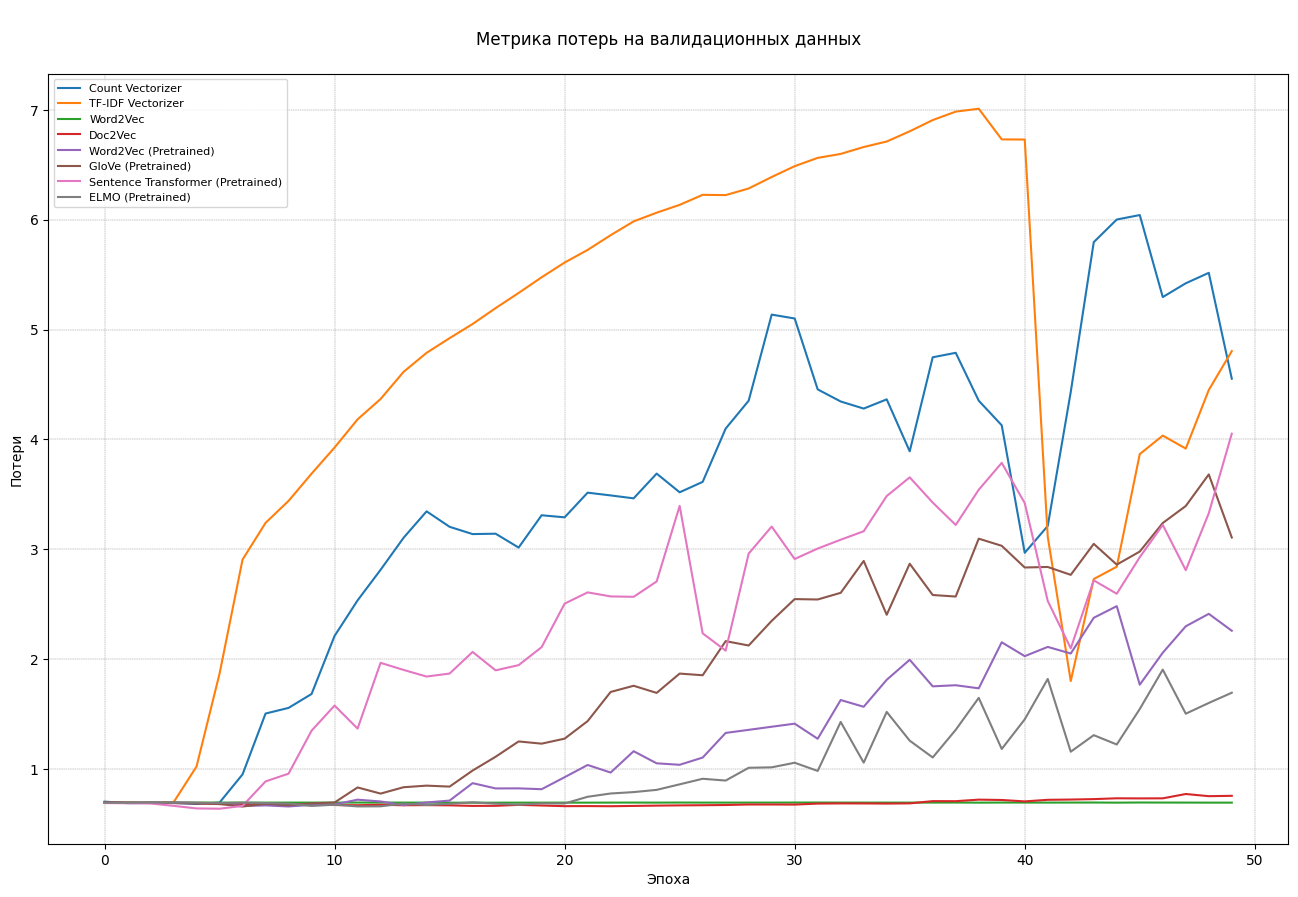

In [66]:
plt.figure(figsize=(16, 10))
for vectorizer in df_nn_compare.index.to_list():
    plt.plot(df_nn_compare['val_loss'][vectorizer])
plt.title('\nМетрика потерь на валидационных данных\n')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.grid(True, color = "grey", linewidth = "0.3", linestyle = "--")
plt.legend(df_nn_compare.index.to_list(), loc='upper left', prop={'size': 8})